<a href="https://colab.research.google.com/github/PervejHosen/Python_Projects/blob/main/Project_14_(EDA_prediction_of_house_rent_in_Dhaka).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pre-processing, EDA and Prediction of House Rent in Dhaka**

Dhaka is one of the most populated megacities of the world. It is the capital of Bangladesh, a country of 164.7m population in the South-East Asian sub-continent. Dhaka is inhabited by over 20 million people, with 75-80% people living in rented houses. The rent hike in the city was recorded 29% in the last five years. Nearly 65 percent or more of the city dwellers' monthly income is spent on paying the rent.

However, house rent vary depending on various factors. We have tried to build a Machine Learning model, using Artificial Neural Network (ANN) in PyTorch, to predict house rent in Dhaka.

The dataset used in this project to train and test the model is webscrapped from [bproperties.com](https://www.bproperty.com/)

In [2]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
!pip install catboost
from catboost import CatBoostRegressor
import os
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.1 MB/s eta 0:00:00


### **Collect Dataset and Create Dataframe**

In [3]:
# Get filename of Kaggle dataset
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv("/content/drive/MyDrive/Python/Datasets/houserentdhaka.csv")
df.head()

,Unnamed: 0,Location,Area,Bed,Bath,Price
0,0,"Block H, Bashundhara R-A, Dhaka","1,600 sqft",3,3,20 Thousand
1,1,"Farmgate, Tejgaon, Dhaka",900 sqft,2,2,20 Thousand
2,2,"Block B, Nobodoy Housing Society, Mohammadpur,...","1,250 sqft",3,3,18 Thousand
3,3,"Gulshan 1, Gulshan, Dhaka","2,200 sqft",3,4,75 Thousand
4,4,"Baridhara, Dhaka","2,200 sqft",3,3,75 Thousand


### **General Inspection**
As observed, there are 3 columns and 28800 rows in the dataset. There is no missing values.

In [7]:
# Get the shape of the dataset
df.shape

(28800, 6)

In [8]:
# Describe dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  28800 non-null  int64 
 1   Location    28800 non-null  object
 2   Area        28800 non-null  object
 3   Bed         28800 non-null  int64 
 4   Bath        28800 non-null  int64 
 5   Price       28800 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.3+ MB


## **Data Pre-processing**

In this step, we are going to perform the following actions for data wrangling:

* Check for column names
* Treating unnecessary columns
* Checking for missing values and treating them
* Formating data and changing datatypes
* One-hot Encoding: Preparing categorical values for Machine Learning (LATER)

In [9]:
# Check for column names
df.columns

Index(['Unnamed: 0', 'Location', 'Area', 'Bed', 'Bath', 'Price'], dtype='object')

**Note:**
* As we can see, the column for Rent is named as Price, which is not a good practice.
* We are going to fix this.

In [10]:
# Rename the header of the column Price as Rent
df.rename({'Price': 'Rent'}, axis=1, inplace=True)

In [11]:
# Treat unnecessary column "Unnamed: 0"
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [12]:
# Check for datatypes
df.dtypes

Location    object
Area        object
Bed          int64
Bath         int64
Rent        object
dtype: object

**There are a few things we need to format in the dataframe:**

* We need to remove the city name from the Location column
* We need to remove sqft from the Area column and remove comma "," from the digits
* We need to change the datatype of the Area column to int64 from object
* We need to turn any string in the Rent column to its neumeric form. For this, we need to turn 65 Thousand into 65000 and 1.5 Lakh into 150000
* We need to also change the datatype of the Rent column to float from object

In [13]:
# Remove city names from the Location column
df['Location']=df['Location'].str.split(',').str[:-1]
# Keep only the thana/PO/area name in the Location column
df['Location'] = df['Location'].str[-1]
# Remove the leading space from the Location strings
df['Location'] = df['Location'].str.strip()

df['Location'].head()

0    Bashundhara R-A
1            Tejgaon
2        Mohammadpur
3            Gulshan
4          Baridhara
Name: Location, dtype: object

In [14]:
# Remove sqft from the Area column and formating the digits
df['Area']=df['Area'].str.split(' ').str[:-1]
# Turn data in the location column into string from list type
df['Area'] = df['Area'].apply(lambda x: ''.join(map(str, x)))
# Remove comma from the digits
df['Area']=df['Area'].str.replace(',', '')
# Change datatype of the Area column to int64 from object
df['Area'] = df['Area'].astype(int)

print("Area Column Data Type:", df['Area'].dtypes)

df['Area'].head()

Area Column Data Type: int64


0    1600
1     900
2    1250
3    2200
4    2200
Name: Area, dtype: int64

In [15]:
# Format the Rent column as required and changing the datatype to int64
df['Rent']=df['Rent'].replace({"Thousand":"*1e3", "Lakh":"*1e5"}, regex=True).map(pd.eval).astype(int)

df['Rent'].head()

0    20000
1    20000
2    18000
3    75000
4    75000
Name: Rent, dtype: int64

In [16]:
# Check for nan values
df.isna().sum()

Location    13
Area         0
Bed          0
Bath         0
Rent         0
dtype: int64

In [17]:
# Drop the rows containing nan values in the Location column
df.dropna(inplace=True)

## **Exploratory Data Analysis (EDA)**

In this step, we are going to perform the following steps:

* Summarize quantitative data by describe()
* Summarize categorical data by value_counts()
* Visualize numeric data with box plot
* Visualize relationship between a feature and the target using scatter plot
* Use correlation to show relationship between two variables
* Show correlation using Pearson Correlation
* Visualize correlation with a heatmap

In [18]:
# Summarize quantitative data
df.describe()

,Area,Bed,Bath,Rent
count,28787.000000,28787.000000,28787.000000,28787.000000
mean,1057.316740,2.510995,2.369750,21009.554799
std,477.767777,0.601339,0.756555,21499.249095
min,200.000000,1.000000,1.000000,5000.000000
25%,700.000000,2.000000,2.000000,13000.000000
50%,900.000000,2.000000,2.000000,16000.000000
75%,1250.000000,3.000000,3.000000,22000.000000
max,6300.000000,6.000000,8.000000,650000.000000


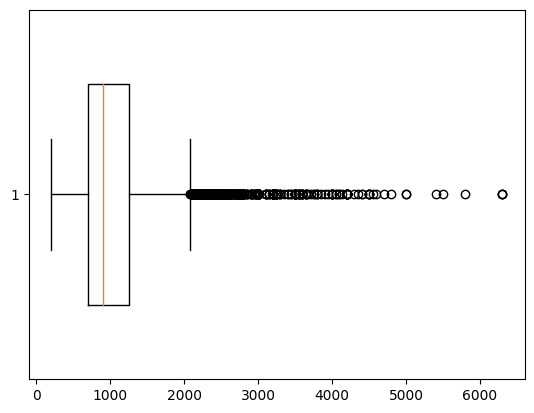

In [19]:
# Visualize quantitative data with boxplot
plt.boxplot(df["Area"], vert=False, widths = 0.6)
plt.show()

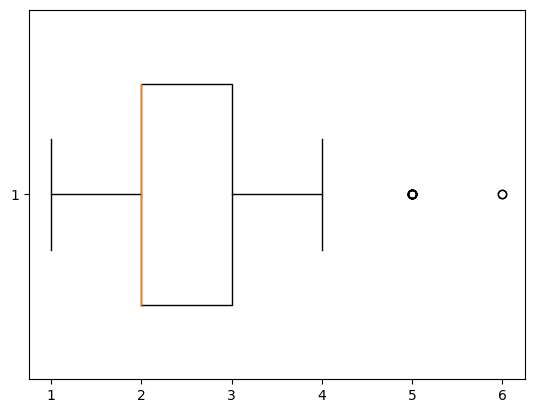

In [20]:
# Visualize quantitative data with boxplot
plt.boxplot(df["Bed"], vert=False, widths = 0.6)
plt.show()

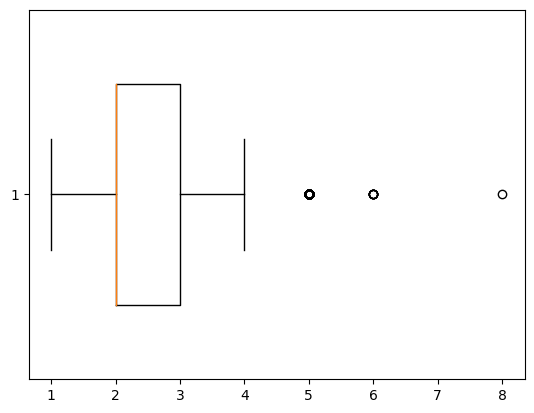

In [21]:
# Visualize quantitative data with boxplot
plt.boxplot(df["Bath"], vert=False, widths = 0.6)
plt.show()

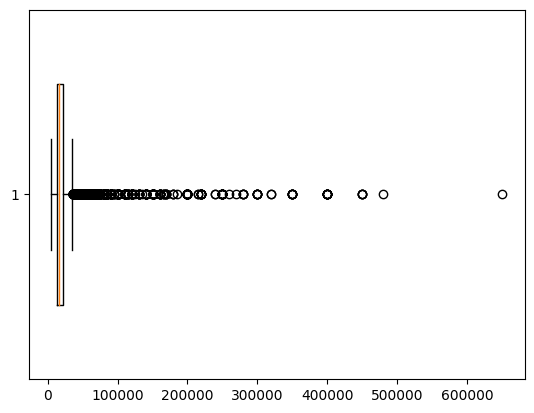

In [22]:
# Visualize quantitative data with boxplot
plt.boxplot(df["Rent"], vert=False, widths = 0.6)
plt.show()

In [23]:
# Summarize categorical data [Location]
df["Location"].value_counts()

Mirpur             8451
Mohammadpur        3612
Uttara             2070
Badda              1831
Bashundhara R-A    1397
                   ... 
Shahbagh              7
Demra                 7
Keraniganj            3
Sadarghat             2
Banglamotors          2
Name: Location, Length: 68, dtype: int64

In [24]:
# Summarize data [Bed]
df["Bed"].value_counts()

2    14272
3    12965
4     1063
1      461
5       24
6        2
Name: Bed, dtype: int64

In [25]:
# Summarize categorical data [Bath]
df["Bath"].value_counts()

2    15765
3     8465
1     2364
4     2046
5      139
6        7
8        1
Name: Bath, dtype: int64

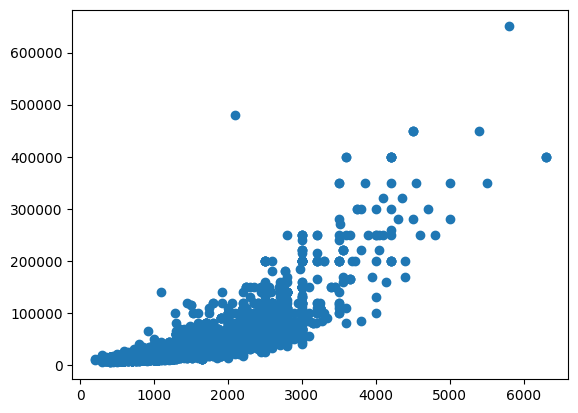

In [26]:
# Show relationship between Area and Rent
plt.scatter(df["Area"], df["Rent"])
plt.show()

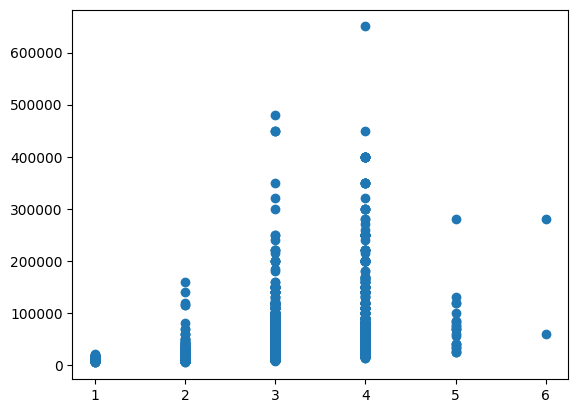

In [27]:
# Show relationship between Bed and Rent
plt.scatter(df["Bed"], df["Rent"])
plt.show()

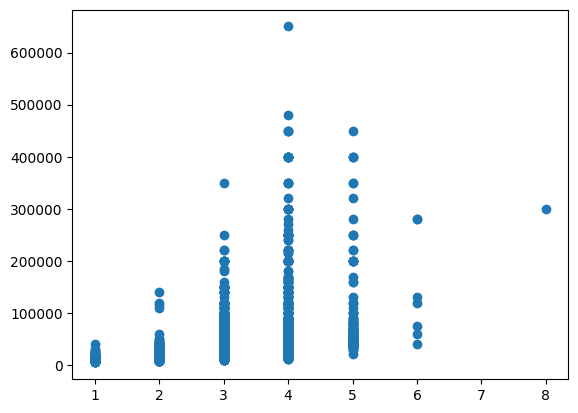

In [28]:
# Show relationship between Bath and Rent
plt.scatter(df["Bath"], df["Rent"])
plt.show()

In [29]:
# Show Pearson's Correlation
df.corr(method ='pearson')

,Area,Bed,Bath,Rent
Area,1.000000,0.774539,0.808109,0.747651
Bed,0.774539,1.000000,0.759157,0.426704
Bath,0.808109,0.759157,1.000000,0.481407
Rent,0.747651,0.426704,0.481407,1.000000


Text(0.5, 1.0, 'Pearson Correlation')

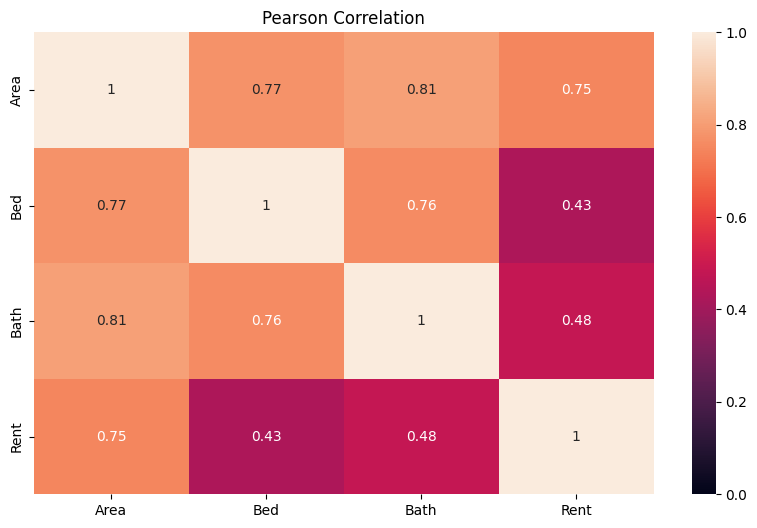

In [30]:
# Create heatmap
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(df.corr(method ='pearson'), vmin=0,vmax=1, annot=True)
plt.title("Pearson Correlation")

**Info:**
* As it is observed, `Area` has the highest impact on Rent (0.75).
* `No. of bedrooms` and `no. of bathrooms` have too little to do with the rent of the houses (0.43 and 0.48, consecutively).

## **Some Questions Answered**

#### **Question 1: Which location has the highest average rent? Show top 5 locations.**

In [31]:
df.groupby(['Location'])['Rent'].mean().sort_values(ascending=False).nlargest(5)

Location
Baridhara         141273.621891
Gulshan           125727.937500
Banani DOHS        98318.181818
Mohakhali DOHS     89727.272727
Banani             81178.564286
Name: Rent, dtype: float64

#### **Question 2: Which location has the lowest average rent? Show bottom 5 locations.**

In [32]:
df.groupby(['Location'])['Rent'].mean().sort_values(ascending=True).nsmallest(5)

Location
Demra           11642.857143
Shyampur        11888.888889
Khilkhet        12058.064516
Dakshin Khan    12060.861423
Uttar Khan      12411.764706
Name: Rent, dtype: float64

#### **Question 3: Which location has the largest houses on average?**

In [33]:
df.groupby(['Location'])['Area'].mean().sort_values(ascending=False).nlargest(5)

Location
Gulshan           2692.720588
Baridhara         2604.925373
Banani DOHS       2466.727273
Mohakhali DOHS    2350.000000
Banani            2295.500000
Name: Area, dtype: float64

#### **Question 4: Which location has the smallest houses on average?**

In [34]:
df.groupby(['Location'])['Area'].mean().sort_values(ascending=True).nsmallest(5)

Location
Sadarghat       675.000000
Kotwali         686.363636
Mohakhali       687.142857
Shahjahanpur    725.254237
Bangshal        726.000000
Name: Area, dtype: float64

#### **Question 5: What is the average house rent in Dhaka?**

In [35]:
print("Average Rent in Dhaka:", df['Rent'].mean())

Average Rent in Dhaka: 21009.554799041234


#### **Question 6: What is the average house size (in sqft) in Dhaka?**

In [36]:
print("Average Size of Houses in Dhaka:", round(df['Area'].mean()))

Average Size of Houses in Dhaka: 1057


## **Feature Creation**
Before jumping into building and training a model, we are going to create a new feature `Avg House Price`. For this, we are going to browse through the website: [bproperty.com](https://www.bproperty.com/) and manually search the house price of different areas. Then we are going to get the average with the highest and the lowest house price in that area.

In [37]:
# Get the names of all locations
df['Location'].unique()

array(['Bashundhara R-A', 'Tejgaon', 'Mohammadpur', 'Gulshan',
       'Baridhara', 'Hazaribag', 'Mirpur', 'Nikunja', 'Uttara',
       'Khilgaon', 'Ibrahimpur', 'Badda', 'Adabor', 'Jatra Bari',
       'Malibagh', 'Banani', 'Kakrail', 'Dhanmondi', 'Maghbazar',
       'Kalachandpur', 'Niketan', 'Eskaton', 'Banasree', 'Bashabo',
       'Baridhara DOHS', 'Aftab Nagar', 'Lalmatia', 'Dakshin Khan',
       'Mohakhali DOHS', 'Sutrapur', 'Hatirpool', 'Agargaon', 'Rampura',
       'Cantonment', 'Shahbagh', 'Khilkhet', 'Motijheel', 'Shantinagar',
       'Shegunbagicha', 'Kathalbagan', 'Shyamoli', 'Kalabagan', 'Demra',
       'Kuril', 'Mohakhali', 'Lalbagh', 'New Market', 'Kafrul',
       'Kachukhet', 'Turag', 'Nadda', 'Shyampur', 'Maniknagar',
       'Banani DOHS', 'Shiddheswari', 'Bangshal', 'Paribagh',
       'Joar Sahara', 'Mugdapara', 'North Shahjahanpur', 'Kotwali',
       'Shahjahanpur', 'Uttar Khan', 'Taltola', 'Sadarghat',
       'Banglamotors', 'Zafrabad', 'Keraniganj'], dtype=object)

In [38]:
avg_price_dict = {
    'Bashundhara R-A': 31700000,
    'Tejgaon': 12000000,
    'Mohammadpur': 27350000,
    'Gulshan': 59750000,
    'Baridhara': 47850000,
    'Hazaribag': 8250000,
    'Mirpur': 23125000,
    'Nikunja': 9000000,
    'Uttara': 30500000,
    'Khilgaon': 18000000,
    'Ibrahimpur': 7150000,
    'Badda': 12100000,
    'Adabor': 12950000,
    'Jatra Bari': 5950000,
    'Malibagh': 11650000,
    'Banani': 32000000,
    'Kakrail': 17050000,
    'Dhanmondi': 31575000,
    'Maghbazar': 10050000,
    'Kalachandpur': 6430000,
    'Niketan': 28250000,
    'Eskaton': 17000000,
    'Banasree': 12450000,
    'Bashabo': 6800000,
    'Baridhara DOHS': 31250000,
    'Aftab Nagar': 14500000,
    'Lalmatia': 23400000,
    'Dakshin Khan': 10300000,
    'Mohakhali DOHS': 31600000,
    'Sutrapur': 10500000,
    'Hatirpool': 11062500,
    'Agargaon': 7450000,
    'Rampura': 10900000,
    'Cantonment': 28100000,
    'Shahbagh': 15900000,
    'Khilkhet': 5530500,
    'Motijheel': 11312000,
    'Shantinagar': 16500000,
    'Shegunbagicha': 17000000,
    'Kathalbagan': 12250000,
    'Shyamoli': 13250000,
    'Kalabagan': 13500000,
    'Demra': 5873000,
    'Kuril': 7575000,
    'Mohakhali': 7800000,
    'Lalbagh': 8257500,
    'New Market': 15100000,
    'Kafrul': 11937500,
    'Kachukhet': 8155000,
    'Turag': 12000000,
    'Nadda': 7150000,
    'Shyampur': 5800000,
    'Maniknagar': 7750000,
    'Banani DOHS': 59750000,
    'Shiddheswari': 17500000,
    'Bangshal': 5550000,
    'Paribagh': 12250000,
    'Joar Sahara': 6550000,
    'Mugdapara': 8850000,
    'North Shahjahanpur': 6840000,
    'Kotwali': 5950000,
    'Shahjahanpur': 6840000,
    'Uttar Khan': 5250000,
    'Taltola': 6000000,
    'Sadarghat': 5950000,
    'Banglamotors': 12250000,
    'Zafrabad': 5150000,
    'Keraniganj': 12250000,
}
# Create a Series by mapping the "Location" column to the dictionary values
avg_price_series = df['Location'].map(avg_price_dict)

# Create a new column "avg_price" using the Series
df['avg_price'] = avg_price_series


In [39]:
# Display the first 5 rows
df.head()

,Location,Area,Bed,Bath,Rent,avg_price
0,Bashundhara R-A,1600,3,3,20000,31700000
1,Tejgaon,900,2,2,20000,12000000
2,Mohammadpur,1250,3,3,18000,27350000
3,Gulshan,2200,3,4,75000,59750000
4,Baridhara,2200,3,3,75000,47850000


### **Scaling the features**
As we can see the columns have values at different scales. So we need to treat this accordingly.

In [40]:
print("Minimum Area:", df['Area'].min())
print("Maximum Area:", df['Area'].max())
print("Minimum Average Price:", df['avg_price'].min())
print("Maximum Average Price:", df['avg_price'].max())

Minimum Area: 200
Maximum Area: 6300
Minimum Average Price: 5150000
Maximum Average Price: 59750000


In [41]:
# Divide values in the "Area" column by 100
df['Area'] = df['Area'] / 100

# Divide values in the "avg_price" column by 1000000
df['avg_price'] = df['avg_price'] / 1000000

df.head()

,Location,Area,Bed,Bath,Rent,avg_price
0,Bashundhara R-A,16.0,3,3,20000,31.70
1,Tejgaon,9.0,2,2,20000,12.00
2,Mohammadpur,12.5,3,3,18000,27.35
3,Gulshan,22.0,3,4,75000,59.75
4,Baridhara,22.0,3,3,75000,47.85


### **Avoiding Sparsity in Dataset**
Let's check the number of locations we have

In [42]:
len(df['Location'].unique())

68

One-hot encoding a categorical column with 68 different locations can potentially lead to a larger and more sparse dataset, which might have implications on memory usage and computation efficiency. Since we already quantified the locations using the average house price, we may drop the `Location` column.

In [43]:
df.drop(['Location'], axis=1, inplace=True)

### **Normalizing Features**

In [44]:
# Columns to normalize
columns_to_normalize = ['Area', 'Bed', 'Bath', 'avg_price']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Display the first 5 rows
df.head()

,Area,Bed,Bath,Rent,avg_price
0,0.229508,0.4,0.285714,20000,0.486264
1,0.114754,0.2,0.142857,20000,0.125458
2,0.172131,0.4,0.285714,18000,0.406593
3,0.327869,0.4,0.428571,75000,1.000000
4,0.327869,0.4,0.285714,75000,0.782051


### **Splitting Train and Test Datasets**

In [45]:
features = df[['Area', 'Bed', 'Bath', 'avg_price']]
target = df['Rent']

# Split the dataset into training and test sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print("Shape of X_train", X_train.shape)
print("Shape of X_test", X_test.shape)
print("Shape of y_train", y_train.shape)
print("Shape of y_test", y_test.shape)

Shape of X_train (23029, 4)
Shape of X_test (5758, 4)
Shape of y_train (23029,)
Shape of y_test (5758,)


## **Model Building & Training**

* We are going to try multiple ML algorithms and Neural Networks.
* To evaluate performance, we are going to use `Mean Squared Error (MSE)`

#### **Machine Learning Models**

In [46]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
lr_mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error: ", np.sqrt(lr_mse))

Root Mean Squared Error:  11846.288923661505


In [47]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error: ", np.sqrt(rf_mse))

Root Mean Squared Error:  7066.18462607061


In [48]:
# XGBoost Regressor
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
xgb_mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error: ", np.sqrt(xgb_mse))

Root Mean Squared Error:  7375.857668006549


In [49]:
# Support Vector Regressor
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
svr_mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error: ", np.sqrt(svr_mse))

Root Mean Squared Error:  20204.0251703601


In [50]:
# Ridge Regressor
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error: ", np.sqrt(ridge_mse))

Root Mean Squared Error:  11838.768406899822


In [51]:
# Lasso Regressor
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error: ", np.sqrt(lasso_mse))

Root Mean Squared Error:  11844.962666356483


In [52]:
# Bayesian Ridge Regressor
bayesian = BayesianRidge()
bayesian.fit(X_train, y_train)
y_pred = bayesian.predict(X_test)
bayesian_mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error: ", np.sqrt(bayesian_mse))

Root Mean Squared Error:  11846.20077636714


In [53]:
# LightGBM Regressor
lgbm = LGBMRegressor(n_estimators=100)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
lgbm_mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error: ", np.sqrt(lgbm_mse))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 23029, number of used features: 4
[LightGBM] [Info] Start training from score 21079.330670
Root Mean Squared Error:  6980.896421463606


In [54]:
# CatBoost Regressor
cat = CatBoostRegressor(iterations=100)
cat.fit(X_train, y_train)
y_pred = cat.predict(X_test)
cat_mse = mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error: ", np.sqrt(cat_mse))

Learning rate set to 0.436937
0:	learn: 14985.0205579	total: 49.9ms	remaining: 4.94s
1:	learn: 11622.2902390	total: 52.7ms	remaining: 2.58s
2:	learn: 9999.4099443	total: 55.1ms	remaining: 1.78s
3:	learn: 9187.8789894	total: 58ms	remaining: 1.39s
4:	learn: 8748.2486466	total: 60.3ms	remaining: 1.15s
5:	learn: 8627.6889465	total: 65ms	remaining: 1.02s
6:	learn: 8563.2048979	total: 67.1ms	remaining: 891ms
7:	learn: 8395.9085291	total: 69.6ms	remaining: 800ms
8:	learn: 8225.2745308	total: 71.8ms	remaining: 726ms
9:	learn: 8134.3619244	total: 74.1ms	remaining: 667ms
10:	learn: 8112.1108373	total: 76.4ms	remaining: 618ms
11:	learn: 8095.2575814	total: 78.6ms	remaining: 576ms
12:	learn: 7978.3329994	total: 80.8ms	remaining: 541ms
13:	learn: 7867.5892951	total: 83.1ms	remaining: 510ms
14:	learn: 7853.6107115	total: 84.9ms	remaining: 481ms
15:	learn: 7812.9562554	total: 87.9ms	remaining: 461ms
16:	learn: 7771.8192545	total: 90.3ms	remaining: 441ms
17:	learn: 7653.4789152	total: 92.8ms	remaining

#### **Neural Network**

In [55]:
# Import dependencies
import torch
import torch.nn as nn
import torch.optim as optim

# Convert data to PyTorch tensors
X = torch.tensor(features.values, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

# Define a simple neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        return x

# Initialize the neural network model
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
model = NeuralNetwork(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.53)

# Train the model
num_epochs = 12000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Root Mean Squared Error: {np.sqrt(mse):.2f}')

Epoch [1000/12000], Loss: 89388640.0000
Epoch [2000/12000], Loss: 83839128.0000
Epoch [3000/12000], Loss: 83435240.0000
Epoch [4000/12000], Loss: 83404624.0000
Epoch [5000/12000], Loss: 82412952.0000
Epoch [6000/12000], Loss: 81653544.0000
Epoch [7000/12000], Loss: 81585504.0000
Epoch [8000/12000], Loss: 81536960.0000
Epoch [9000/12000], Loss: 81517112.0000
Epoch [10000/12000], Loss: 81511200.0000
Epoch [11000/12000], Loss: 81508600.0000
Epoch [12000/12000], Loss: 81505184.0000
Root Mean Squared Error: 8620.87


### **Hyperparameter Tuning for XGBoost**
As of now, we have received the lowest `Root Mean Squared Error` with `XGBoost` We'll now optimize its hyperparameters using `grid search` method.

In [56]:
# Define features and target variable
features = df[['Area', 'Bed', 'Bath', 'avg_price']]
target = df['Rent']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Define hyperparameter grid for tuning
param_grid = {
    'n_estimators': [275, 287, 300, 312, 325],
    'max_depth': [2],
    'learning_rate': [0.225, 0.2375, 0.25, 0.2625, 0.275]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform hyperparameter tuning on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the search
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Use the best model to make predictions on the test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate Mean Squared Error (MSE) for the best model
mse = mean_squared_error(y_test, y_pred)
print(f'Best Model Root Mean Squared Error: {np.sqrt(mse):.2f}')

Best Hyperparameters: {'learning_rate': 0.275, 'max_depth': 2, 'n_estimators': 312}
Best Model Root Mean Squared Error: 7179.88


### **Testing with Unseen Data**

Real data: [https://www.bproperty.com/en/property/details-4504949.html](https://www.bproperty.com/en/property/details-4504949.html)

Location: Banani DOHS

True Rent: 80000.00 taka

In [57]:
new_data = [[20, 3, 3, 59.75]]

# Normalize the new data using the same scaler as used during training
normalized_new_data = scaler.transform(new_data)  # Use the same 'scaler' you used during training

# Make predictions on the normalized new data
predicted_rent = best_model.predict(normalized_new_data)

print(f'Predicted Rent: {predicted_rent[0]:.2f}')

Predicted Rent: 72647.98


Real data: [https://www.bproperty.com/en/property/details-5151813.html](https://www.bproperty.com/en/property/details-5151813.html)

Location: Mohammadpur

True Rent: 27000.00 taka

In [58]:
new_data = [[17, 3, 3, 27.35]]

# Normalize the new data using the same scaler as used during training
normalized_new_data = scaler.transform(new_data)  # Use the same 'scaler' you used during training

# Make predictions on the normalized new data
predicted_rent = best_model.predict(normalized_new_data)

print(f'Predicted Rent: {predicted_rent[0]:.2f}')

Predicted Rent: 26713.36


Real data: [https://www.bproperty.com/en/property/details-3863920.html](https://www.bproperty.com/en/property/details-3863920.html)

Location: After Nagar

True Rent: 32000.00 taka

In [59]:
new_data = [[20, 3, 3, 14.5]]

# Normalize the new data using the same scaler as used during training
normalized_new_data = scaler.transform(new_data)  # Use the same 'scaler' you used during training

# Make predictions on the normalized new data
predicted_rent = best_model.predict(normalized_new_data)

print(f'Predicted Rent: {predicted_rent[0]:.2f}')

Predicted Rent: 40309.69


Real data: [https://www.bproperty.com/en/property/details-4793899.html](https://www.bproperty.com/en/property/details-4793899.html)

Location: Hatirpool

True Rent: 48000.00 taka

In [60]:
new_data = [[23.7, 3, 4, 11.0625]]

# Normalize the new data using the same scaler as used during training
normalized_new_data = scaler.transform(new_data)  # Use the same 'scaler' you used during training

# Make predictions on the normalized new data
predicted_rent = best_model.predict(normalized_new_data)

print(f'Predicted Rent: {predicted_rent[0]:.2f}')

Predicted Rent: 51527.26


## **Limitations**

This dataset lacks some relavant information about the listings, such as which floor the house is in, if lift/elevator is available, if generation service is available, etc. If these features were available, it would be able to predict the rent more accurately.